In [2]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import numpy as np
import os
import glob
import xarray as xr
import utils
from LoopTimer import LoopTimer
import met_utils as mu
from importlib import reload
import pickle
from scipy.stats import linregress
import inversion_heights as inv
import datetime as dt
from subprocess import check_call
import lagrangian_case as lc
import CSET_data_classes as cd
from geopy import distance

%load_ext autoreload
%autoreload 2

In [3]:
# def get_leg_times_by_sequence(flightnum, sequence, leg):
#     path = r'/home/disk/eos4/jkcm/Data/CSET/LookupTable_all_flights.xls'
#     flight = cu.read_CSET_Lookup_Table(path, rf_num=flightnum, sequences=[sequence],
#                                        legs=[leg], variables=['Date', 'ST', 'ET'])
#     start_times = utils.as_datetime([cu.CSET_date_from_table(d, t) for d, t in
#                    zip(flight['Date']['values'], flight['ST']['values'])])
#     end_times = utils.as_datetime([cu.CSET_date_from_table(d, t) for d, t in
#                  zip(flight['Date']['values'], flight['ET']['values'])])
#     sounding_times = list(zip(flight['rf'], start_times, end_times))
#     return(sounding_times[0][1], sounding_times[0][2])

In [4]:
rf06B_profile_time = utils.get_leg_times_by_sequence(flightnum=6, sequence='B', leg='d') # for traj 3.0
rf07B_profile_time = utils.get_leg_times_by_sequence(flightnum=7, sequence='B', leg='d') # for traj 3.0

rf06C_profile_time = utils.get_leg_times_by_sequence(flightnum=6, sequence='C', leg='d') # for traj 2.3
rf07A_profile_time = utils.get_leg_times_by_sequence(flightnum=7, sequence='A', leg='d') # for traj 2.3

rf10A_profile_time = utils.get_leg_times_by_sequence(flightnum=10, sequence='A', leg='d') # for traj 6.0
rf11E_profile_time = utils.get_leg_times_by_sequence(flightnum=11, sequence='E', leg='d') # for traj 6.0

rf10B_profile_time = utils.get_leg_times_by_sequence(flightnum=10, sequence='B', leg='d') # for traj 5.5
rf11D_profile_time = utils.get_leg_times_by_sequence(flightnum=11, sequence='D', leg='d') # for traj 5.5



rf10_cloud_time = utils.get_leg_times_by_sequence(flightnum=10, sequence='A', leg='c')
rf11_cloud_time = utils.get_leg_times_by_sequence(flightnum=11, sequence='E', leg='c')

In [5]:
tlc_rf06 = lc.TrajectoryCase(lc.all_cases[6]["TLC_name"])
tlc_rf10 = lc.TrajectoryCase(lc.all_cases[10]["TLC_name"])

In [8]:
model_case_rf06_1 = {"out_flight": 6,
                     "ret_flight": 7,
                     "traj": "3.0",
                     "goes_file": r'/home/disk/eos4/jkcm/Data/CSET/model_forcings/case_rf06bc-rf07a/GOES_rf06_rf07-3.0-2deg.nc',
                     "traj_file": r'/home/disk/eos4/jkcm/Data/CSET/model_forcings/case_rf06bc-rf07a/rf06_ERA_data_3.0.nc',
                     "out_profile_time": rf06B_profile_time,
                     "ret_profile_time": rf07B_profile_time
                     }

model_case_rf06_2 = {"out_flight": 6,
                     "ret_flight": 7,
                     "traj": "2.3",
                     "goes_file": r'/home/disk/eos4/jkcm/Data/CSET/model_forcings/case_rf06bc-rf07a/GOES_rf06_rf07-2.3-2deg.nc',
                     "traj_file": r'/home/disk/eos4/jkcm/Data/CSET/model_forcings/case_rf06bc-rf07a/rf06_ERA_data_2.3.nc',
                     "out_profile_time": rf06C_profile_time,
                     "ret_profile_time": rf07A_profile_time
                     }

model_case_rf10_1 = {"out_flight": 10,
                     "ret_flight": 11,
                     "traj": "6.0",
                     "goes_file": r'/home/disk/eos4/jkcm/Data/CSET/model_forcings/case_rf10a-rf11de/GOES_rf10_rf11-6.0-2deg.nc',
                     "traj_file": r'/home/disk/eos4/jkcm/Data/CSET/model_forcings/case_rf10a-rf11de/rf10_ERA_data_6.0.nc',
                     "out_profile_time": rf10A_profile_time,
                     "ret_profile_time": rf11E_profile_time
                     }

model_case_rf10_2 = {"out_flight": 10,
                     "ret_flight": 11,
                     "traj": "5.5",
                     "goes_file": r'/home/disk/eos4/jkcm/Data/CSET/model_forcings/case_rf10a-rf11de/GOES_rf10_rf11-5.5-2deg.nc',
                     "traj_file": r'/home/disk/eos4/jkcm/Data/CSET/model_forcings/case_rf10a-rf11de/rf10_ERA_data_5.5.nc',
                     "out_profile_time": rf10B_profile_time,
                     "ret_profile_time": rf11D_profile_time
                     }

model_cases = [model_case_rf06_1, model_case_rf06_2, model_case_rf10_1, model_case_rf10_2]

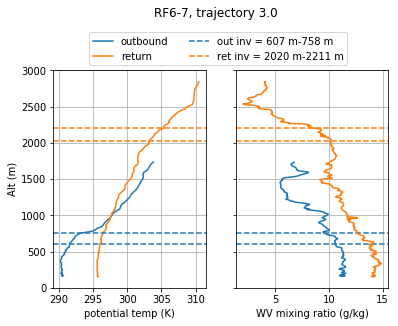

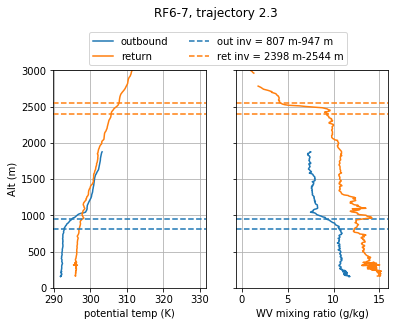

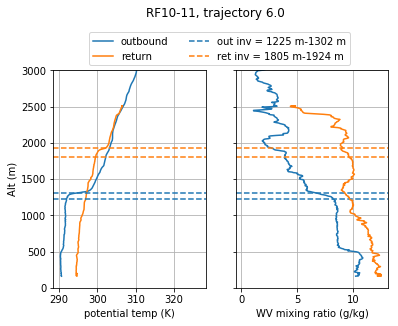

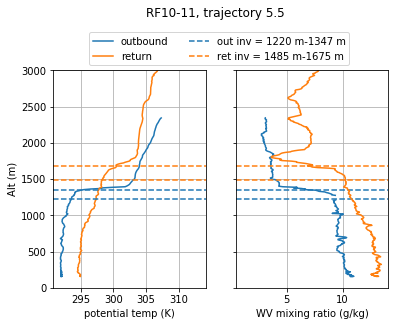

In [51]:
def get_case_profiles(case):
    out_profile = cd.CSET_Flight_Piece("RF{:02d}".format(case['out_flight']), *case['out_profile_time'])
    ret_profile = cd.CSET_Flight_Piece("RF{:02d}".format(case['ret_flight']), *case['ret_profile_time'])
    

    
    get_inversions=True
    if get_inversions:
        out_heff = mu.heffter_pblht_1D(out_profile.flight_data.GGALT, out_profile.flight_data.THETA)
        ret_heff = mu.heffter_pblht_1D(ret_profile.flight_data.GGALT, ret_profile.flight_data.THETA)
        
        warn_string=''
        if not out_heff['inversion']:
            warn_string.append("(could not find true outbound inversion)")
        if not ret_heff['inversion']:
            if len(warn_string>2):
                warn_string.append(' ')
            warn_string.append("(could not find true return inversion)")
        
        
        fig, [ax1, ax2] = plt.subplots(ncols=2, sharey=True)
        p1 = ax1.plot(out_profile.flight_data.THETA, out_profile.flight_data.GGALT, label='outbound')
        p2 = ax1.plot(ret_profile.flight_data.THETA, ret_profile.flight_data.GGALT, label='return')

        ax1.axhline(out_heff['z_bot'], c=p1[0].get_color(), ls='--', label='out inv = {:0.0f} m-{:0.0f} m'.format(out_heff['z_bot'], out_heff['z_top']))
        ax1.axhline(out_heff['z_top'], c=p1[0].get_color(), ls='--')

        ax1.axhline(ret_heff['z_bot'], c=p2[0].get_color(), ls='--', label='ret inv = {:0.0f} m-{:0.0f} m'.format(ret_heff['z_bot'], ret_heff['z_top']))
        ax1.axhline(ret_heff['z_top'], c=p2[0].get_color(), ls='--')
        ax1.set_ylabel("Alt (m)")
        ax1.set_xlabel("potential temp (K)")
        
        ax2.plot(out_profile.flight_data.MR, out_profile.flight_data.GGALT, label='outbound', color=p1[0].get_color())
        ax2.axhline(out_heff['z_bot'], c=p1[0].get_color(), ls='--', label='out inv = {:0.0f} m'.format(out_heff['z_bot']))
        ax2.axhline(out_heff['z_top'], c=p1[0].get_color(), ls='--')

        ax2.plot(ret_profile.flight_data.MR, ret_profile.flight_data.GGALT, label='return', c=p2[0].get_color())
        ax2.axhline(ret_heff['z_bot'], c=p2[0].get_color(), ls='--', label='ret inv = {:0.0f} m'.format(ret_heff['z_bot']))
        ax2.axhline(ret_heff['z_top'], c=p2[0].get_color(), ls='--')

        plt.suptitle("RF{}-{}, trajectory {}".format(case["out_flight"], case["ret_flight"], case["traj"]) + warn_string, y=1.1)
        ax2.set_xlabel("WV mixing ratio (g/kg)")
        ax1.legend(loc='lower left', ncol=2, bbox_to_anchor=(0.2, 1))
        ax1.grid(True)
        ax2.grid(True)
        ax2.set_ylim(0, 3000)
        
        
        savename = "RF{}-{}_traj_{}_profiles.png".format(case["out_flight"], case["ret_flight"], case["traj"])
        fig.savefig(os.path.join(utils.plot_dir, savename), dpi=300)

    
    
    report_misses = False
    if report_misses:
        
        #calculating how terrible these locations are
        with xr.open_dataset(case["traj_file"]) as data:
            traj_lats = data['lat']
            traj_lons = data['lon']
            traj_time = data['time']

        out_time_i = np.argmin(abs(utils.as_datetime(traj_time.values) - utils.as_datetime(case['out_profile_time'][0])))
        ret_time_i = np.argmin(abs(utils.as_datetime(traj_time.values) - utils.as_datetime(case['ret_profile_time'][0])))

        lat_traj_out, lon_traj_out = traj_lats[out_time_i], traj_lons[out_time_i]
        lat_prof_out, lon_prof_out = np.nanmean(out_profile.flight_data['GGLAT'].values), np.nanmean(out_profile.flight_data['GGLON'].values)
        out_dist = distance.distance((lat_traj_out, lon_traj_out), (lat_prof_out, lon_prof_out)).kilometers

        lat_traj_ret, lon_traj_ret = traj_lats[ret_time_i], traj_lons[ret_time_i]
        lat_prof_ret, lon_prof_ret = np.nanmean(ret_profile.flight_data['GGLAT'].values), np.nanmean(ret_profile.flight_data['GGLON'].values)
        ret_dist = distance.distance((lat_traj_ret, lon_traj_ret), (lat_prof_ret, lon_prof_ret)).kilometers


        print("model case {} from RF{:02d}-RF{:02d}".format(case['traj'], case['out_flight'], case['ret_flight']))
        print("out profile missed traj by {:0.0f} km. At time {:%Y-%m-%d %H:%M} (i={})".format(
            out_dist, utils.as_datetime(traj_time[out_time_i].values), out_time_i))
        print("ret profile missed traj by {:0.0f} km. At time {:%Y-%m-%d %H:%M} (i={})".format(
            ret_dist, utils.as_datetime(traj_time[ret_time_i].values), ret_time_i))

    save_profiles = False
    if save_profiles:
        out_profile_savename = "rf{:02d}_traj_{}_initprofile.nc".format(case['out_flight'], case['traj'])
        out_profile.flight_data.to_netcdf(os.path.join(os.path.dirname(case['traj_file']), out_profile_savename))    
        ret_profile_savename = "rf{:02d}_traj_{}_returnprofile.nc".format(case['ret_flight'], case['traj'])
        ret_profile.flight_data.to_netcdf(os.path.join(os.path.dirname(case['traj_file']), ret_profile_savename))

    check_goes = False
    if check_goes:
        with xr.open_dataset(case['goes_file']) as goes_data:
            goes_lat = goes_data['trajectory_latitude']
            goes_lon = goes_data['trajectory_longitude']
            goes_time= goes_data['time']

        fig, [ax1, ax2] = plt.subplots(nrows=2)
        ax1.plot(goes_lat, goes_lon, label='GOES')
        ax1.plot(traj_lats, traj_lons, '--', label='traj')
        ax1.legend()
        ax1.plot(goes_lat, time )

    
    return out_profile, ret_profile



for model_case in model_cases:
    out, ret = get_case_profiles(model_case)

In [5]:
flight, (start_time, end_time) = 6, rf06_profile_time
print(start_time)
print(end_time)
var_list = ['GGLAT', 'GGLON', 'GGALT', 'RHUM', 'ATX', 'MR', 'THETAE', 'THETA', 'PSX', 'DPXC', 'PLWCC', 'CONCD_LWOI']
sounding = inv.get_data_from_flight(flight, start_time, end_time, var_list)
zi = inv.calc_zi_from_sounding(sounding)    
print(zi)

dec = inv.calc_decoupling_from_sounding(sounding)
print(dec)

2015-07-17 17:46:33+00:00
2015-07-17 17:50:49+00:00
0.0
{'lon': -137.33833, 'Heff': {'theta_top': 294.9159683401174, 'z_top': 947.2664228228682, 'i_bot': 138, 'theta_bot': 292.7679917873248, 'i_top': 120, 'inversion': True, 'z_bot': 806.8229411945465}, 'RH50': {'z': nan, 'inversion': False, 'i': nan}, 'lat': 34.520145, 'lon_p': -136.06260833740234, 'time': datetime.datetime(2015, 7, 17, 17, 46, 33, tzinfo=<UTC>), 'RHCB': {'z': 752.8370971679688, 'inversion': True, 'RH': 99.72540855407715, 'i': 145}}
{'d_qt': -0.43887424, 'd_theta_l': 0.48788452, 'alpha_thetal': 0.050558973, 'alpha_qt': 0.12508608, 'd_theta_e': -0.69018555, 'alpha_thetae': -1.0171809}


In [ ]:
sounding.keys()
plt.plot(sounding['TIME'], sounding['CONCD_LWOI'])
plt.grid(True)
plt.title("in-cloud leg CDP conc ({:3.1f}N, {:3.1f}E), {:%Y-%m-%d %H:%MUTC}".format(zi['lat'], zi['lon'], zi['time']))
plt.ylabel("CDP Conc (#/cm3)")
plt.xlabel("time")
#plt.savefig("/home/disk/p/jkcm/RF11_E_cloudleg.png")

In [ ]:
plt.plot(sounding['ATX'], sounding['GGALT'])
plt.grid(True)
plt.title("GV sounding at ({:3.1f}N, {:3.1f}E), {:%Y-%m-%d %H:%MUTC}".format(zi['lat'], zi['lon'], zi['time']))
plt.ylabel("altitude (m)")
plt.xlabel("temperature (K)")
plt.savefig("/home/disk/p/jkcm/RF06_C_downsounding.png")

In [98]:
flight_file = r'/home/disk/eos4/jkcm/Data/CSET/flight_data/RF11.20150729.163000_000800.PNI.nc.nc'
save_name = r'/home/disk/eos4/jkcm/Data/CSET/model_forcings/rf11_traj_6.0_initprofile.nc'
start_time = sounding_times[0][1]
end_time = sounding_times[0][2]
def chop_flight_file(flight_file, start_date, end_date, save_name):
    call = "cdo seldate,{:%Y-%m-%dT%H:%M:%S},{:%Y-%m-%dT%H:%M:%S} {} {}".format(start_date, end_date, flight_file, save_name)
    print(call)
    #check_call(call, shell=False, cwd = '/home/disk/p/jkcm')

    return

In [99]:
chop_flight_file(flight_file, start_time, end_time, save_name)

cdo seldate,2015-07-29T20:51:10,2015-07-29T20:56:53 /home/disk/eos4/jkcm/Data/CSET/flight_data/RF11.20150729.163000_000800.PNI.nc.nc /home/disk/eos4/jkcm/Data/CSET/model_forcings/rf11_traj_6.0_resample_profile.nc
